# **LOAN DEFAULT PREDICTION** | LENDING CLUB

### **1. IMPORT LIBRARIES**

In [540]:
import pandas as pd                                       # data preprocessing
import numpy as np                                        # matrix math
from scipy import stats                                   # math operations

import matplotlib.pyplot as plt                           # data visualization
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15,10)
import seaborn as sns
sns.set(style='whitegrid')

import warnings                                           # ignore warnigns
warnings.filterwarnings("ignore")

### **2. IMPORT DATASET** ([Lending Club data CSV file](https://www.lendingclub.com/info/download-data.action))

In [541]:
# read data from CSV file
df_loan = pd.read_csv('./data/lending_club_loans.csv', skiprows=1, low_memory=False) 

### **3. ANALYSE DATA**

In [542]:
# Print a concise summary of a DataFrame
df_loan.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Columns: 115 entries, id to total_il_high_credit_limit
dtypes: float64(90), object(25)
memory usage: 37.3+ MB


In [543]:
# Return the first five rows.
df_loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### **4. PREPROCESS DATA**

#### 4.1 REMOVE MISSING VALUES

In [544]:
# Drop any column with more than 50% of missing values
df_loan = df_loan.dropna(thresh=(len(df_loan)/2), axis=1)

In [545]:
# delete rows with missing values in 'member_id' and 'delinq_2yrs' columns
drop_rows = df_loan[df_loan['delinq_2yrs'].isnull()].index.tolist()
df_loan = df_loan.drop(drop_rows, axis=0)

In [546]:
# Drop all columns with some missing values
df_loan = df_loan.dropna(axis=1)

# number of missing values
df_loan.isnull().sum().sum()

0

#### 4.2 REMOVE OUTLIERS

In [547]:
# keep only the ones that are within +3 to -3 standard deviations in the column.
for column_name in df_loan.columns.tolist():
    if df_loan[column_name].dtype == np.float64:
        df_loan[column_name] = df_loan[column_name][np.abs(df_loan[column_name]-df_loan[column_name].mean()) <= (3*df_loan[column_name].std())]

In [548]:
# Drop all columns with some missing values
df_loan = df_loan.dropna(axis=0)

# number of missing values
df_loan.isnull().sum().sum()

0

#### 4.3 MODIFY CATEGORICAL DATA

In [549]:
#  visualize categorical columns
df_loan.select_dtypes(include=['object']).head()

,id,term,int_rate,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,1077501,36 months,10.65%,B,B2,RENT,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,860xx,AZ,Jan-1985,f,INDIVIDUAL
2,1077175,36 months,15.96%,C,C5,RENT,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,606xx,IL,Nov-2001,f,INDIVIDUAL
3,1076863,36 months,13.49%,C,C1,RENT,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,other,917xx,CA,Feb-1996,f,INDIVIDUAL
4,1075358,60 months,12.69%,B,B5,RENT,Source Verified,Dec-2011,Current,n,https://lendingclub.com/browse/loanDetail.acti...,other,972xx,OR,Jan-1996,f,INDIVIDUAL
5,1075269,36 months,7.90%,A,A4,RENT,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,wedding,852xx,AZ,Nov-2004,f,INDIVIDUAL


In [550]:
# convert 'id' column from string object to number
df_loan['id'] = df_loan['id'].astype(int)

# remove word: months from column 'term'
df_loan['term'] = df_loan['term'].map(lambda x: x.rstrip(' months')).astype(int)

# remove % from column 'int_rate'
df_loan['int_rate'] = df_loan['int_rate'].map(lambda x: x.lstrip(' ').rstrip('%')).astype('float64')

In [551]:
# print unique values of non-numeric columns
print('Unique values of grade: {}\n'.format(df_loan['grade'].unique()))
print('Unique values of sub_grade: {}\n'.format(df_loan['sub_grade'].unique()))
print('Unique values of home_ownership: {}\n'.format(df_loan['home_ownership'].unique()))
print('Unique values of verification_status: {}\n'.format(df_loan['verification_status'].unique()))
print('Unique values of pymnt_plan: {}\n'.format(df_loan['pymnt_plan'].unique()))
print('Unique values of purpose: {}\n'.format(df_loan['purpose'].unique()))
print('Unique values of addr_state: {}\n'.format(df_loan['addr_state'].unique()))
print('Unique values of initial_list_status: {}\n'.format(df_loan['initial_list_status'].unique()))
print('Unique values of application_type: {}\n'.format(df_loan['application_type'].unique()))

Unique values of grade: ['B' 'C' 'A' 'E' 'D' 'F' 'G']

Unique values of sub_grade: ['B2' 'C5' 'C1' 'B5' 'A4' 'E1' 'C3' 'B1' 'D1' 'C4' 'A1' 'B4' 'B3' 'C2'
 'A3' 'A5' 'D5' 'D2' 'A2' 'E4' 'D3' 'F2' 'E3' 'D4' 'F1' 'F3' 'E5' 'E2'
 'F5' 'F4' 'G2' 'G3' 'G1' 'G4' 'G5']

Unique values of home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']

Unique values of verification_status: ['Verified' 'Not Verified' 'Source Verified']

Unique values of pymnt_plan: ['n']

Unique values of purpose: ['credit_card' 'small_business' 'other' 'wedding' 'debt_consolidation'
 'car' 'home_improvement' 'major_purchase' 'moving' 'medical' 'vacation'
 'house' 'renewable_energy' 'educational']

Unique values of addr_state: ['AZ' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'FL' 'NY' 'MN' 'KY' 'OH'
 'SC' 'NJ' 'PA' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'KS' 'NV' 'MD' 'GA' 'WV'
 'VT' 'MI' 'DC' 'SD' 'NH' 'AR' 'NM' 'CO' 'MT' 'HI' 'AK' 'UT' 'OK' 'WY'
 'DE' 'MS' 'IA' 'TN' 'NE' 'ID' 'IN' 'ME']

Unique values of initial_list_status: ['f'

In [552]:
# Convert all above columns to categorical data
df_loan['grade'] = df_loan['grade'].astype('category', categories=['G', 'F', 'E', 'D', 'C', 'B', 'A'], ordered=True)
df_loan['sub_grade'] = df_loan['sub_grade'].astype('category', categories=['G5', 'G4', 'G3', 'G2', 'G1', 'F5', 'F4', 'F3', 'F2', 'F1', 'E5', 'E4', 'E3', 'E2', 'E1', 'D5', 'D4', 'D3', 'D2', 'D1', 'C5', 'C4', 'C3', 'C2', 'C1', 'B5', 'B4', 'B3', 'B2', 'B1', 'A5', 'A4', 'A3', 'A2', 'A1'], ordered=True)
df_loan['home_ownership'] = df_loan['home_ownership'].astype('category', categories=df_loan['home_ownership'].unique(), ordered=False)
df_loan['verification_status'] = df_loan['verification_status'].astype('category', categories=['Verified', 'Source Verified', 'Not Verified'], ordered=True)
df_loan['pymnt_plan'] = df_loan['pymnt_plan'].astype('category', categories=['n', 'y'], ordered=True)
df_loan['purpose'] = df_loan['purpose'].astype('category', categories=df_loan['purpose'].unique(), ordered=False)
df_loan['addr_state'] = df_loan['addr_state'].astype('category', categories=df_loan['addr_state'].unique(), ordered=False)
#df_loan['loan_status'] = df_loan['loan_status'].astype('category', categories=df_loan['loan_status'].unique(), ordered=False)

In [553]:
# drop not necessary columns
df_loan = df_loan.drop(['initial_list_status', 'application_type', 'url', 'zip_code', 'earliest_cr_line'], axis=1)

#### 4.4 CONVERT TO DATETIME

In [554]:
# convert to datetime
df_loan['issue_d'] = pd.to_datetime(df_loan['issue_d'])
df_loan['issue_d_year'] = df_loan['issue_d'].dt.year
df_loan['issue_d_month'] = df_loan['issue_d'].dt.month
df_loan['issue_d_year_month'] = df_loan['issue_d'].dt.to_period('M')

In [555]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33134 entries, 0 to 42514
Data columns (total 45 columns):
id                         33134 non-null int64
member_id                  33134 non-null float64
loan_amnt                  33134 non-null float64
funded_amnt                33134 non-null float64
funded_amnt_inv            33134 non-null float64
term                       33134 non-null int64
int_rate                   33134 non-null float64
installment                33134 non-null float64
grade                      33134 non-null category
sub_grade                  33134 non-null category
home_ownership             33134 non-null category
annual_inc                 33134 non-null float64
verification_status        33134 non-null category
issue_d                    33134 non-null datetime64[ns]
loan_status                33134 non-null object
pymnt_plan                 33134 non-null category
purpose                    33134 non-null category
addr_state                 33134 

### **5. STATISTICAL FEATURES**

It include concepts such as bias, variace, mean, median and many others.

In [556]:
df_loan_11 = df_loan[df_loan['issue_d_year'] == 2011]
df_loan_10 = df_loan[df_loan['issue_d_year'] == 2010]
df_loan_09 = df_loan[df_loan['issue_d_year'] == 2009]
df_loan_08 = df_loan[df_loan['issue_d_year'] == 2008]
df_loan_07 = df_loan[df_loan['issue_d_year'] == 2007]

In [557]:
# Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset's distribution
df_loan.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,...,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,policy_code,acc_now_delinq,delinq_amnt,issue_d_year,issue_d_month
count,3.313400e+04,3.313400e+04,33134.000000,33134.000000,33134.000000,33134.000000,33134.000000,33134.000000,33134.000000,33134.000000,...,33134.000000,33134.000000,33134.000000,33134.000000,33134.000000,33134.0,33134.0,33134.0,33134.000000,33134.000000
mean,6.639692e+05,8.258805e+05,10003.149333,9767.132704,9216.703607,41.318766,11.555758,294.470614,62675.164872,13.313258,...,35.594037,2.376604,2176.794300,697.817408,693.817227,1.0,0.0,0.0,2010.244794,7.093167
std,2.140413e+05,2.724007e+05,6090.148651,5848.069697,5837.134528,9.968155,3.508520,177.929022,33894.914739,6.730399,...,173.026342,21.152404,3211.287367,73.396411,73.396036,0.0,0.0,0.0,0.933219,3.403309
min,5.473400e+04,7.069400e+04,500.000000,500.000000,0.000000,36.000000,5.420000,15.670000,1896.000000,0.000000,...,0.000000,0.000000,0.000000,504.000000,500.000000,1.0,0.0,0.0,2007.000000,1.000000
25%,5.007332e+05,6.424562e+05,5000.000000,5000.000000,4875.000000,36.000000,8.590000,160.847500,40000.000000,8.090000,...,0.000000,0.000000,211.317500,654.000000,650.000000,1.0,0.0,0.0,2010.000000,4.000000
50%,6.419800e+05,8.214550e+05,9000.000000,8800.000000,8000.000000,36.000000,11.490000,261.880000,55000.000000,13.390000,...,0.000000,0.000000,511.375000,704.000000,700.000000,1.0,0.0,0.0,2011.000000,7.000000
75%,8.197100e+05,1.027240e+06,14000.000000,13225.000000,12500.000000,36.000000,13.980000,389.300000,78000.000000,18.610000,...,0.000000,0.000000,2950.467500,754.000000,750.000000,1.0,0.0,0.0,2011.000000,10.000000
max,1.077501e+06,1.313524e+06,32000.000000,31200.000000,30975.000000,60.000000,23.590000,946.890000,260735.000000,29.990000,...,2240.160000,490.540800,15770.340000,850.000000,845.000000,1.0,0.0,0.0,2011.000000,12.000000


#### 4.1 Box Plot

Examine relationship between income and loan amount. Boxplots are standard way of displaying the distribution of data based on a view statistical features.

In [558]:
df_loan['annual_inc'].shape, df_loan['loan_status'].shape

((33134,), (33134,))

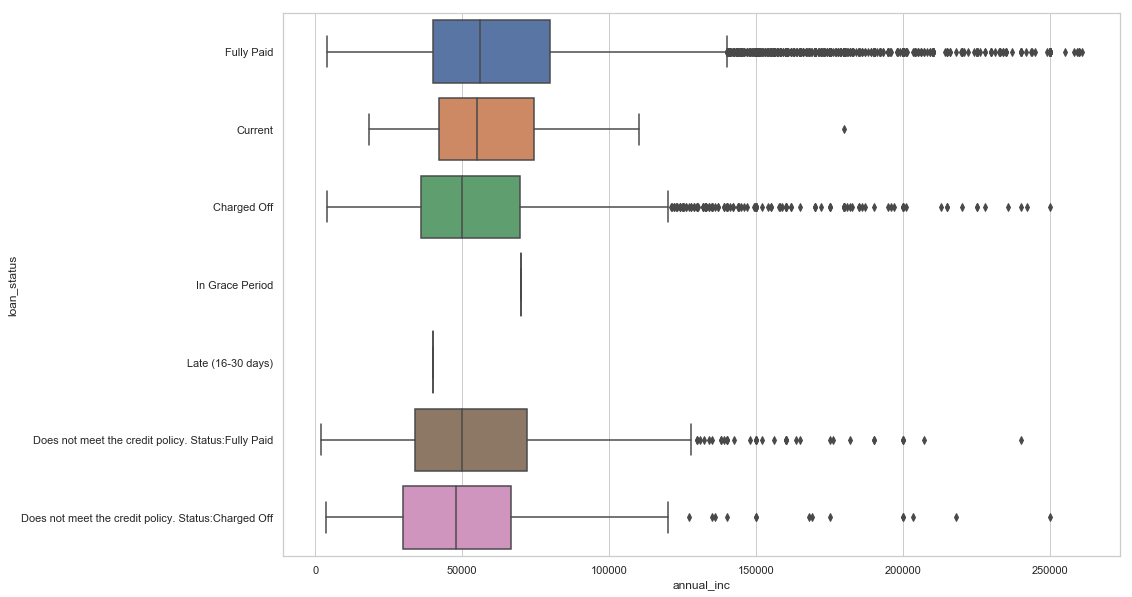

In [560]:
ax = sns.boxplot(x=df_loan['annual_inc'], y=df_loan['loan_status'])

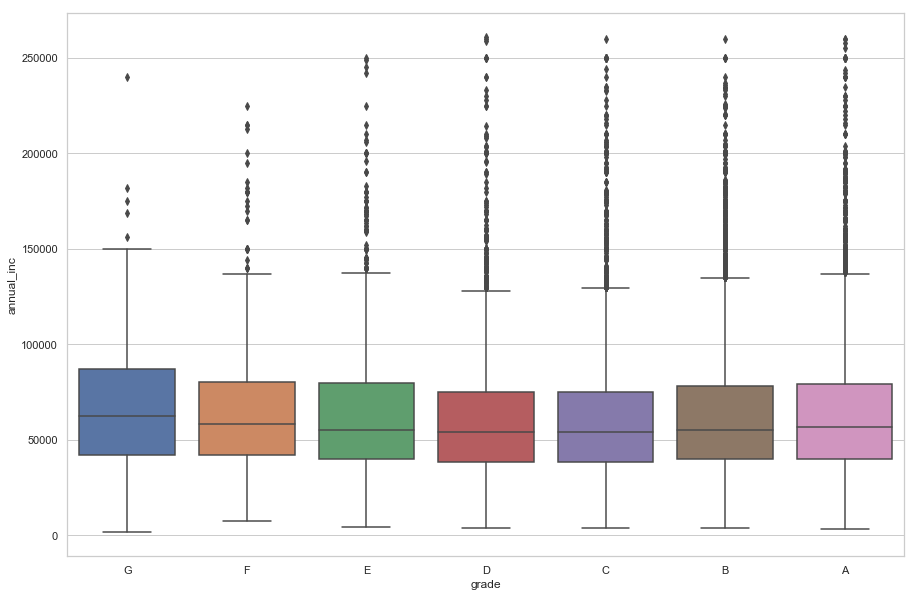

In [561]:
ax = sns.boxplot(x=df_loan['grade'], y=df_loan['annual_inc'])

#### 4.2 Probability Distribution

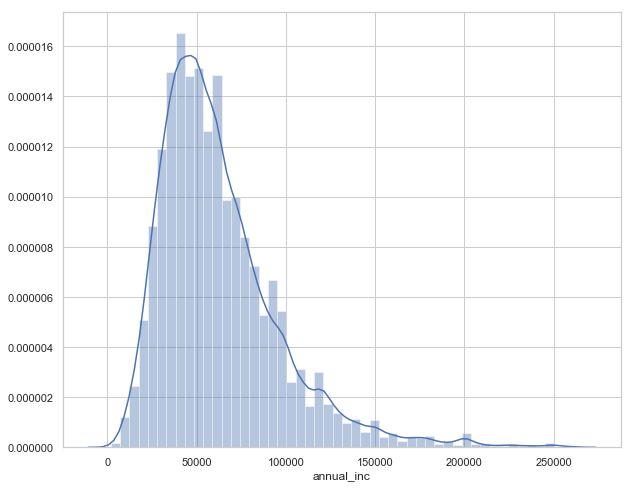

In [568]:
plt.figure(figsize = (10, 8))
g = sns.distplot(df_loan['annual_inc'])
g.set_xlabel('annual_inc', fontsize=12)
plt.show()

#### 4.3. Bayesian Statistics

In [522]:
print('Unique values of loan_status: {}\n'.format(df_loan['loan_status'].unique()))

Unique values of loan_status: ['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (16-30 days)' 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']



In [523]:
# modify column 'loan_status'
display(df_loan.shape)
df_loan = df_loan.drop(df_loan[df_loan['loan_status'] == 'Current'].index.tolist(), axis=0)
df_loan = df_loan.drop(df_loan[df_loan['loan_status'] == 'In Grace Period'].index.tolist(), axis=0)
df_loan = df_loan.drop(df_loan[df_loan['loan_status'] == 'Late (31-120 days)'].index.tolist(), axis=0)
df_loan = df_loan.drop(df_loan[df_loan['loan_status'] == 'Late (16-30 days)'].index.tolist(), axis=0)
df_loan = df_loan.drop(df_loan[df_loan['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index.tolist(), axis=0)
df_loan = df_loan.drop(df_loan[df_loan['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index.tolist(), axis=0)

df_loan['loan_status'][df_loan['loan_status'] == 'Fully Paid'] = 1
df_loan['loan_status'][df_loan['loan_status'] == 'Default'] = 1
df_loan['loan_status'][df_loan['loan_status'] == 'Charged Off'] = 0

df_loan.shape

(33134, 45)

(31686, 45)